In [1]:
import pandas as pd
import spacy
import nltk
import re
import unidecode
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import os

In [2]:
df = pd.read_parquet(r"D:\Python for Data Analysis\alerj\leis-ordinarias\todos\leis_ordinarias.parquet")

In [3]:
#criar uma coluna data_proposicao ao reconhecer na coluna tramitacao o texto "[Data: mm/dd/yyyy]"
df['data_proposicao'] = df['tramitacao'].str.extract(r'\[Data:\s*(\d{2}/\d{2}/\d{4})\]').squeeze()
df['data_proposicao'] = pd.to_datetime(df['data_proposicao'], format='%m/%d/%Y', errors='coerce')

#criar coluna legislação
#se 2011 <= ano <= 2014 em data_proposicao -> Legislação 2011-2015
#se 2015 <= ano <= 2018 em data_proposicao -> Legislação 2015-2019
#se 2019 <= ano <= 2022 em data_proposicao -> Legislação 2019-2023
def classify_legislation(date):
    if pd.isna(date):
        return 'Desconhecido'
    year = date.year
    if 2011 <= year <= 2014:
        return 'Legislação 2011-2015'
    elif 2015 <= year <= 2018:
        return 'Legislação 2015-2019'
    elif 2019 <= year <= 2022:
        return 'Legislação 2019-2023'
    else:
        return 'Fora do intervalo'
df['legislacao'] = df['data_proposicao'].apply(classify_legislation)
df[['data_proposicao', 'legislacao']].head(10)

,data_proposicao,legislacao
0,2011-02-04,Legislação 2011-2015
1,2011-02-04,Legislação 2011-2015
2,2011-02-04,Legislação 2011-2015
3,2011-02-04,Legislação 2011-2015
4,2011-02-04,Legislação 2011-2015
5,2011-02-04,Legislação 2011-2015
6,2011-02-04,Legislação 2011-2015
7,2011-02-04,Legislação 2011-2015
8,2011-02-04,Legislação 2011-2015
9,2011-02-04,Legislação 2011-2015


Processando análise semântica...
Total de leis analisadas: 14416
Leis relevantes sobre criminalidade/violência: 1567

Gerando análises de aprovação por categoria e evolução temporal...


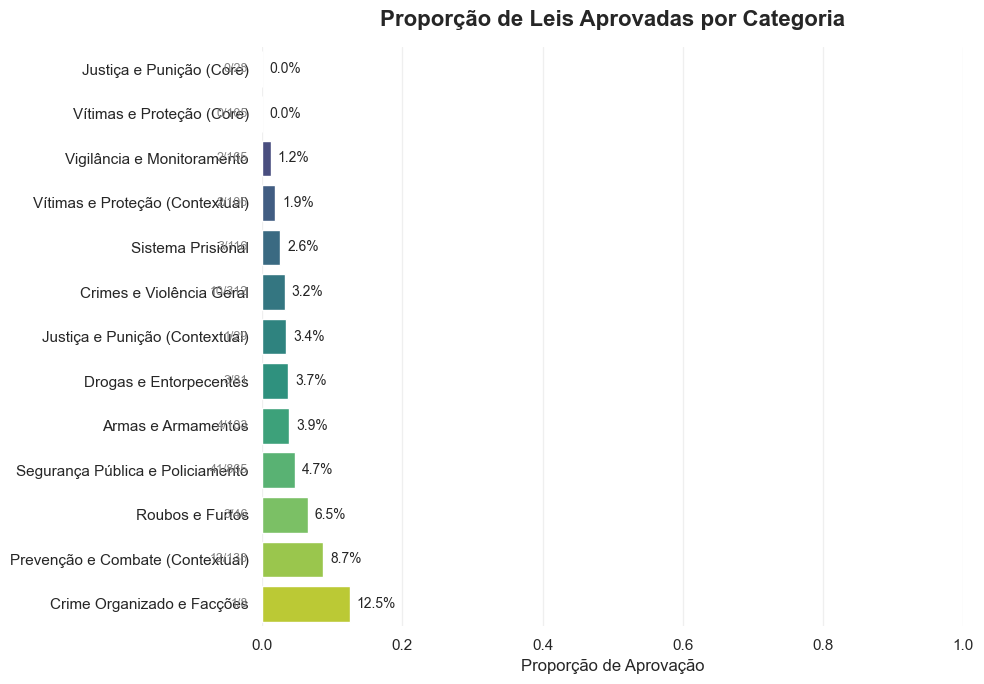

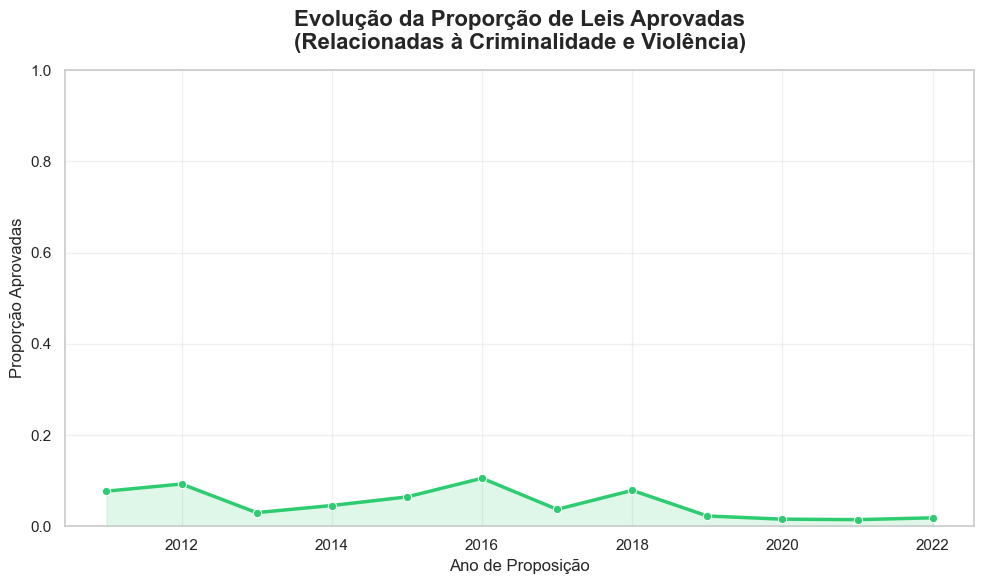


Análise concluída.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
import ast

# Configurações
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# 1. DICIONÁRIOS TEMÁTICOS

DICIONARIO_CORE = {
    'crimes_violencia': ['crime', 'criminal', 'criminoso', 'criminalidade', 'criminosa', 'violencia', 'violento', 'violenta', 'delito', 'infracão', 'ilicito', 'ilegal', 'vandalismo', 'depredacao', 'homicidio', 'assassinato', 'latrocinio', 'feminicidio', 'agressao', 'lesao corporal', 'violencia fisica'],
    'crime_organizado': ['organizacao criminosa', 'crime organizado', 'organizacoes criminosas', 'faccao', 'faccoes', 'quadrilha', 'bando', 'gang', 'gangue', 'milicia', 'milicias', 'miliciano', 'milicianos', 'trafico', 'traficante', 'traficantes', 'narcotraficante', 'cartel', 'mafia', 'comando vermelho', 'terceiro comando', 'tcp', 'cv', 'acp'],
    'armas': ['arma', 'armas', 'armamento', 'armamentos', 'arma de fogo', 'armas de fogo', 'fogo', 'fuzil', 'fuzis', 'pistola', 'revolver', 'rifle', 'municao', 'municoes', 'bala', 'balas', 'projetil', 'explosivo', 'explosivos', 'bomba', 'granada', 'porte de arma', 'posse de arma', 'comercio de armas', 'armamento belico', 'arsenal', 'desarmamento', 'desarmar'],
    'drogas': ['droga', 'drogas', 'entorpecente', 'entorpecentes', 'narcotico', 'narcoticos', 'substancia ilicita', 'cocaina', 'crack', 'maconha', 'cannabis', 'dependencia quimica', 'dependente quimico', 'combate as drogas', 'prevencao drogas'],
    'roubos_furtos': ['roubo', 'roubos', 'assalto', 'assaltos', 'furto', 'furtos', 'latrocinio', 'extorsao', 'sequestro', 'carcere privado', 'estelionato', 'fraude'],
    'seguranca_publica': ['seguranca publica', 'seguranca urbana', 'policia', 'policial', 'policiais', 'policiamento', 'militar', 'militares', 'pm', 'pmerj', 'policia civil', 'policia militar', 'delegacia', 'delegado', 'guarda municipal', 'guardas municipais', 'operacao policial', 'abordagem policial', 'forca nacional', 'exercito'],
    'prisional': ['presidio', 'presidios', 'prisao', 'prisoes', 'cadeia', 'cadeias', 'penitenciaria', 'penitenciarias', 'detento', 'detentos', 'preso', 'presos', 'carcere', 'carceraria', 'carcerario', 'reintegracao', 'ressocializacao', 'regime fechado', 'regime semiaberto'],
    'vigilancia_monitoramento': ['camera', 'cameras', 'cftv', 'videomonitoramento', 'vigilancia', 'monitoramento', 'alarme', 'alarmes', 'cerca eletrica', 'seguranca eletronica', 'rastreamento', 'gps'],
    'vitimas_protecao_core': ['violencia domestica', 'violencia mulher', 'abuso sexual', 'estupro', 'assedio sexual'],
    'justica_punicao_core': ['pena', 'penas', 'punir', 'condenacao', 'condena', 'sentenca', 'reclusao', 'detencao'],
}

DICIONARIO_CONTEXTUAL = {
    'prevencao_combate': ['prevencao', 'prevenir', 'preventivo', 'combate', 'combater', 'enfrentamento', 'reducao criminalidade', 'controle criminalidade', 'ostensivo', 'repressao', 'reprimir'],
    'justica_punicao_contextual': ['punicao', 'tribunal', 'judiciario', 'justica', 'penalidade', 'sancao', 'multa'],
    'vitimas_protecao_contextual': ['vitima', 'vitimas', 'vitimizacao', 'revitimizacao', 'protecao testemunha', 'protecao vitima', 'assedio'],
}

EXCLUSOES_HARD = [
    'crime de responsabilidade', 'crime eleitoral', 'crime ambiental',
    'abuso de autoridade', 'abuso do poder economico',
    'estatuto do servidor', 'plano de carreira', 'concurso publico',
    'orcamentarias', 'diretrizes orcamentarias',
    'assedio moral'
]

BOOSTERS = [
    'combate ao', 'combate a', 'prevencao ao', 'prevencao a',
    'enfrentamento ao', 'enfrentamento a', 'reducao do', 'reducao da'
]

PESOS_CATEGORIA = {
    'crime_organizado': 3.0, 'armas': 2.5, 'crimes_violencia': 2.0, 'drogas': 2.0,
    'roubos_furtos': 1.5, 'prisional': 1.5, 'seguranca_publica': 1.0,
    'vigilancia_monitoramento': 1.0, 'vitimas_protecao_core': 2.0, 'justica_punicao_core': 1.5,
    'prevencao_combate': 1.2, 'justica_punicao_contextual': 0.8, 'vitimas_protecao_contextual': 1.0,
}

nomes_categorias = {
    'crimes_violencia': 'Crimes e Violência Geral',
    'crime_organizado': 'Crime Organizado e Facções',
    'armas': 'Armas e Armamentos',
    'drogas': 'Drogas e Entorpecentes',
    'roubos_furtos': 'Roubos e Furtos',
    'seguranca_publica': 'Segurança Pública e Policiamento',
    'prisional': 'Sistema Prisional',
    'vigilancia_monitoramento': 'Vigilância e Monitoramento',
    'justica_punicao_core': 'Justiça e Punição (Core)',
    'vitimas_protecao_core': 'Vítimas e Proteção (Core)',
    'prevencao_combate': 'Prevenção e Combate (Contextual)',
    'justica_punicao_contextual': 'Justiça e Punição (Contextual)',
    'vitimas_protecao_contextual': 'Vítimas e Proteção (Contextual)',
}

# 2. FUNÇÕES DE PROCESSAMENTO

def normalizar_texto(texto):
    if pd.isna(texto): return ""
    texto = texto.lower()
    substituicoes = {
        'á': 'a', 'à': 'a', 'ã': 'a', 'â': 'a', 'ä': 'a',
        'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
        'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
        'ó': 'o', 'ò': 'o', 'õ': 'o', 'ô': 'o', 'ö': 'o',
        'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
        'ç': 'c', 'ñ': 'n'
    }
    for original, substituto in substituicoes.items():
        texto = texto.replace(original, substituto)
    return texto

def _buscar_termos_no_texto(texto_norm, dicionario, pesos):
    score = 0
    detalhes = defaultdict(list)
    palavras_encontradas = []

    for categoria, palavras in dicionario.items():
        peso = pesos.get(categoria, 1.0)
        
        for palavra in palavras:
            palavra_norm = normalizar_texto(palavra)
            
            if len(palavra_norm.split()) == 1:
                pattern = r'\b' + re.escape(palavra_norm) + r'\b'
            else:
                pattern = re.escape(palavra_norm)
            
            matches = len(re.findall(pattern, texto_norm))
            
            if matches > 0:
                score += matches * peso
                detalhes[categoria].append((palavra, matches))
                palavras_encontradas.append(palavra)
    
    return score, detalhes, palavras_encontradas

def analise_semantica_robusta(texto_norm, dic_core, dic_contextual, pesos, exclusoes, boosters):
    if not texto_norm:
        return 0, {}, False
    
    for termo_ex in exclusoes:
        termo_norm = normalizar_texto(termo_ex)
        if re.search(re.escape(termo_norm), texto_norm):
            return 0, {}, False

    score_core, detalhes_core, palavras_core = _buscar_termos_no_texto(
        texto_norm, dic_core, pesos
    )

    if score_core == 0:
        return 0, {}, False
    
    score_contextual, detalhes_contextual, palavras_contextual = _buscar_termos_no_texto(
        texto_norm, dic_contextual, pesos
    )

    score_total = score_core + score_contextual
    
    detalhes_total = defaultdict(list, detalhes_core)
    for categoria, items in detalhes_contextual.items():
        detalhes_total[categoria].extend(items)
        
    palavras_total = list(set(palavras_core + palavras_contextual))

    boost_factor = 1.0
    for termo_boost in boosters:
        termo_norm = normalizar_texto(termo_boost)
        if re.search(re.escape(termo_norm), texto_norm):
            boost_factor = 1.5
            break
            
    score_total *= boost_factor
    
    return score_total, dict(detalhes_total), palavras_total

# 3. PROCESSAMENTO E CRIAÇÃO DE df_relevantes

df['texto_normalizado'] = df['ementa'].apply(normalizar_texto)

resultados = df['texto_normalizado'].apply(
    lambda x: analise_semantica_robusta(
        x, DICIONARIO_CORE, DICIONARIO_CONTEXTUAL, 
        PESOS_CATEGORIA, EXCLUSOES_HARD, BOOSTERS
    )
)
df['score_relevancia'], df['detalhes_categorias'], df['palavras_encontradas'] = zip(*resultados)

df['relevante'] = df['score_relevancia'] > 0
df_relevantes = df[df['relevante']].copy()
df_relevantes = df_relevantes.sort_values('score_relevancia', ascending=False)

print(f"Total de leis analisadas: {len(df)}")
print(f"Leis relevantes sobre criminalidade/violência: {len(df_relevantes)}")

# 4. ANÁLISE DE APROVAÇÃO E EVOLUÇÃO TEMPORAL

print("\nGerando análises de aprovação por categoria e evolução temporal...")

# Normalização de detalhes_categorias
def ensure_dict(x):
    if isinstance(x, dict):
        return x
    if pd.isna(x):
        return {}
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, dict) else {}
        except Exception:
            return {}
    return {}

df_relevantes['detalhes_categorias'] = df_relevantes['detalhes_categorias'].apply(ensure_dict)
df_relevantes['aprovada'] = df_relevantes['aprovada'].astype(bool)

# GRÁFICO 1: PROPORÇÃO DE APROVAÇÃO POR CATEGORIA

proporcao_aprovadas = []
for cat_id, cat_nome in nomes_categorias.items():
    mask = df_relevantes['detalhes_categorias'].apply(lambda d: cat_id in d)
    subset = df_relevantes[mask]
    total_cat = len(subset)
    aprovadas = int(subset['aprovada'].sum()) if total_cat > 0 else 0
    proporcao = (aprovadas / total_cat) if total_cat > 0 else 0.0
    proporcao_aprovadas.append((cat_nome, total_cat, aprovadas, proporcao))

df_aprov_cat = pd.DataFrame(proporcao_aprovadas, columns=['Categoria', 'Total', 'Aprovadas', 'Proporção'])
df_aprov_cat = df_aprov_cat.sort_values('Proporção', ascending=True)  # Menor proporção no topo

plt.figure(figsize=(10, 7))
palette = sns.color_palette("viridis", len(df_aprov_cat))
ax = sns.barplot(
    data=df_aprov_cat,
    y='Categoria', x='Proporção',
    palette=palette,
    order=df_aprov_cat['Categoria']  # Garante ordenação correta
)
plt.title('Proporção de Leis Aprovadas por Categoria', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Proporção de Aprovação', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(df_aprov_cat.iterrows()):
    plt.text(row['Proporção'] + 0.01, i, f"{row['Proporção']*100:.1f}%", va='center', fontsize=10)
    plt.text(-0.02, i, f"{int(row['Aprovadas'])}/{int(row['Total'])}", va='center', ha='right', fontsize=9, color='gray')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# GRÁFICO 2: EVOLUÇÃO TEMPORAL DA PROPORÇÃO APROVADA

if 'data_proposicao' in df_relevantes.columns:
    df_relevantes['data_proposicao'] = pd.to_datetime(df_relevantes['data_proposicao'], errors='coerce')
    df_relevantes['ano'] = df_relevantes['data_proposicao'].dt.year
    df_temporal = (
        df_relevantes.groupby('ano')
        .agg(total=('aprovada', 'count'), aprovadas=('aprovada', 'sum'))
        .assign(proporcao=lambda x: x['aprovadas'] / x['total'])
        .reset_index()
        .dropna(subset=['ano'])
    )
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_temporal,
        x='ano', y='proporcao',
        marker='o', linewidth=2.5, color='#2ecc71'
    )
    plt.fill_between(df_temporal['ano'], df_temporal['proporcao'], alpha=0.15, color='#2ecc71')
    plt.title('Evolução da Proporção de Leis Aprovadas\n(Relacionadas à Criminalidade e Violência)',
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Ano de Proposição', fontsize=12)
    plt.ylabel('Proporção Aprovadas', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'data_proposicao' não encontrada - análise temporal não gerada.")